# Notebook to generate the plots for the paper

### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
from scipy import signal
import pathlib
import itertools
import glob
import json

In [3]:
import seaborn as sns

In [4]:
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec

### Custom Modules

In [5]:
sys.path.append("../scripts")

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

import misc

In [6]:
import gmac

In [7]:
# Define the font family and size
# font = {'family': 'sans-serif', 'sans-serif': ['Helvetica']}

# # Set the font properties for various elements
# plt.rc('font', **font)

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight
# plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})


## Define notebook level constants

In [8]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)

In [9]:
# Generate all possible combinations of parameters.
def generate_param_combinations_am(param_ranges: dict) -> dict:
    """
    Generate all possible combinations of parameters.
    """
    for _fc in param_ranges["fc"]:
        for _nc in param_ranges["nc"]:
            for _nam in param_ranges["nam"]:
                yield {
                    "fc": _fc,
                    "nc": int(_nc),
                    "nam": int(_nam)
                }

## Read the Controls and Patients Data

In [10]:
# Read healthy and control data
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Assign segments for each subject
left = pd.concat([misc.assign_segments(left[left.subject == subj], dur_th=1, dT=dT)
                  for subj in left.subject.unique()], axis=0)
right = pd.concat([misc.assign_segments(right[right.subject == subj], dur_th=1, dT=dT)
                   for subj in right.subject.unique()])
aff = pd.concat([misc.assign_segments(aff[aff.subject == subj], dur_th=1, dT=dT)
                 for subj in aff.subject.unique()])
unaff = pd.concat([misc.assign_segments(unaff[unaff.subject == subj], dur_th=1, dT=dT)
                   for subj in unaff.subject.unique()])

# All limbs data ddf
datadf = {
    "left": left,
    "right": right,
    "aff": aff,
    "unaff": unaff
}

## Read the Pitch and Accl. Mag. Estimation files

In [11]:
basedir = "../data/output-r1"

# Read gmac parameters.
with open(pathlib.Path(basedir, "gmac", "gmac_params.json"), "r") as f:
    gmac_param_ranges = json.load(f)

In [12]:
# Read pitch, gm, and gmac performance file
gmac_perf = pd.read_csv(pathlib.Path(basedir, "gmac", "perf_gmac.csv"))

## Read Subash et 2022 results file

In [13]:
# Read data from Tanya's paper
tempdf = pd.read_csv("../data/subash22data.csv")
del tempdf["Unnamed: 0"]

# Organize data into dictionary
limbsdef = {
    "left": "left",
    "right": "right",
    "aff": "affected",
    "unaff": "unaffected"
}
subash22df = {
    lk: tempdf[tempdf.hand == lv].reset_index(drop=True)
    for lk, lv in limbsdef.items()
}

In [14]:
# Limbs
limbs = ["left", "right", "aff", "unaff"]
subash_perf_gmac = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "GMAC"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    subash_perf_gmac["youden"].append(subash22df[limb][_inx]["youden"].values)
    subash_perf_gmac["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
    subash_perf_gmac["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# RF Intersubject
subash_perf_rfinter = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "RF inter"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    subash_perf_rfinter["youden"].append(subash22df[limb][_inx]["youden"].values)
    subash_perf_rfinter["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
    subash_perf_rfinter["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# RF Intrasubject
subash_perf_rfintra = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "RF intra"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    subash_perf_rfintra["youden"].append(subash22df[limb][_inx]["youden"].values)
    subash_perf_rfintra["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
    subash_perf_rfintra["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# RF Intrasubject mean
subash_perf_rfintra_mean = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "RF intra"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    subash_perf_rfintra_mean["youden"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)
    subash_perf_rfintra_mean["sensitivity"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)
    subash_perf_rfintra_mean["specificity"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)

## GMAC Performance: Inter-Subject without validation

In [15]:
# Number of all possible combinations
Ncombs = len(list(misc.generate_param_combinations_gmac(gmac_param_ranges)))

# All parameter combinations.
param_combs_enum = list(misc.generate_param_combinations_gmac_wenum(gmac_param_ranges))

In [17]:
# Generate data for heatmap
# Get performance for the different parameters combinations.
_keys = ["np", "fc", "nc", "nam", "p_th", "p_th_band", "am_th", "am_th_band"]
lens = [len(gmac_param_ranges[_k]) for _k in _keys]
perf = np.zeros(lens)
med = np.zeros(lens)
iqr = np.zeros(lens)
limbs = ["left", "right", "aff", "unaff"]
for i, pcvalenum in enumerate(param_combs_enum):
    _ix, _pcval = pcvalenum
    # Go through all limbs
    _vals = []
    # for l, _lmb in enumerate(limbs):
    _inx = ((gmac_perf.np == _pcval["np"]) &
            (gmac_perf.fc == _pcval["fc"]) &
            (gmac_perf.nc == _pcval["nc"]) &
            (gmac_perf.nam == _pcval["nam"]) &
            (gmac_perf.am_th == _pcval["am_th"]) &
            (gmac_perf.am_th_band == _pcval["am_th_band"]) &
            (gmac_perf.p_th == _pcval["p_th"]) &
            (gmac_perf.p_th_band == _pcval["p_th_band"]))
    _vals.append(gmac_perf.loc[_inx, "youden"].values)
    _ixstr = [f"{k}: {v:2d}" for k, v in _ix.items()]
    sys.stdout.write(f"\r{i:5d} {', '.join(_ixstr)}")
    sys.stdout.flush()
    # Compute the cost.
    _vals = np.hstack(_vals)
    # Computer performance
    _perfs = [np.percentile(_vals, q) for q in [25, 50, 75]]
    _i = tuple(_ix[_k] for _k in _keys)
    perf[_i] = _perfs[1] * (1 - (_perfs[2] - _perfs[0]))
    med[_i] = _perfs[1]
    iqr[_i] = _perfs[2] - _perfs[0]

# Save the perf data as a numpy file
np.save("../data/output-r1/all_perf.npy", perf)

 7694 np:  2, fc:  2, nc:  0, nam:  2, p_th: 18, p_th_band:  4, am_th:  2, am_th_band:  0

In [68]:
# Maximum performance
# ["np", "fc", "nc", "nam", "p_th", "p_th_band", "am_th", "am_th_band"]
_perf = perf[:, :, :, :, ::-1, :, :, :]
maxperf = np.max(_perf)
maxinx = np.where(_perf == maxperf)
bestarg = [
    gmac_param_ranges["np"][maxinx[0][0]],
    gmac_param_ranges["fc"][maxinx[1][0]],
    gmac_param_ranges["nc"][maxinx[2][0]],
    gmac_param_ranges["nam"][maxinx[3][0]],
    gmac_param_ranges["p_th"][::-1][maxinx[4][0]],
    gmac_param_ranges["p_th_band"][maxinx[5][0]],
    gmac_param_ranges["am_th"][maxinx[6][0]],
    gmac_param_ranges["am_th_band"][maxinx[7][0]]
]
bestarg

[50, 0.01, 2, 50, 10, 40, 0.1, 0]

In [69]:
# How different is the maximum?
_perf = perf[:, :, :, :, ::-1, :, :, :]
# Maximum performance
maxperf = np.max(_perf)
minperf = np.min(_perf)
_inx = (100 * (_perf - minperf) / (maxperf - minperf)) > 95
perfinx = np.where(_inx)
topperf = _perf[perfinx]
topperfparam = np.array([
    [
        gmac_param_ranges["np"][perfinx[0][i]],
        gmac_param_ranges["fc"][perfinx[1][i]],
        gmac_param_ranges["nc"][perfinx[2][i]],
        gmac_param_ranges["nam"][perfinx[3][i]],
        gmac_param_ranges["p_th"][::-1][perfinx[4][i]],
        gmac_param_ranges["p_th_band"][perfinx[5][i]],
        gmac_param_ranges["am_th"][perfinx[6][i]],
        gmac_param_ranges["am_th_band"][perfinx[7][i]],
        topperf[i]
    ]
    for i in range(len(perfinx[0]))
])
# Sort by performance
_inxpersort = np.argsort(topperf)[::-1]
topperfparam = topperfparam[_inxpersort, :]
perfinxsort = np.array(perfinx).T[_inxpersort, :]
np.set_printoptions(precision=4, suppress=True)
print(topperfparam)

[[50.      0.01    2.     50.     10.     40.      0.1     0.      0.4091]
 [50.      0.01    2.     25.     10.     40.      0.1     0.      0.4087]
 [25.      0.01    2.     50.     20.     60.      0.1     0.      0.4056]
 [50.      0.1     2.     25.     10.     40.      0.1     0.      0.402 ]
 [25.      0.01    2.     25.     20.     60.      0.1     0.      0.4015]
 [50.      0.01    2.      1.     10.     40.      0.1     0.      0.3998]
 [50.      0.1     2.     50.     10.     40.      0.1     0.      0.3979]
 [25.      0.01    2.      1.     20.     60.      0.1     0.      0.3911]
 [50.      0.01    2.     25.     10.     60.      0.1     0.      0.3897]
 [50.      0.1     2.      1.     10.     40.      0.1     0.      0.3895]]


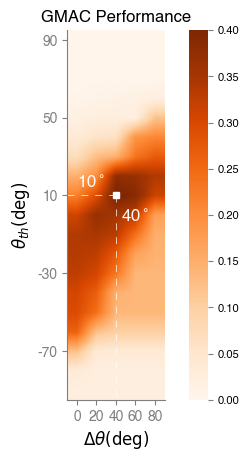

In [70]:
fig = plt.figure()
maxinx = perfinxsort[0]

ax = fig.add_subplot(1, 1, 1)
# Create the heatmap using imshow
_hm = ax.imshow(_perf[perfinxsort[0, 0],
                      perfinxsort[0, 1],
                      perfinxsort[0, 2],
                      perfinxsort[0, 3],
                      :, :,
                      perfinxsort[0, 6],
                      perfinxsort[0, 7]], cmap='Oranges', interpolation='bilinear',
                vmin=0, vmax=0.4)

ax.set_ylabel(r'$\theta_{th} (\deg)$', fontsize=12)
ax.set_yticks(np.arange(len(gmac_param_ranges["p_th"])),
              labels=gmac_param_ranges["p_th"][::-1],
              color="tab:gray")
ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
ax.spines["left"].set_visible(True)
ax.spines["left"].set_color("tab:gray")
ax.yaxis.set_tick_params(color='tab:grey')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_color("tab:gray")

# Set x ticks
ax.set_xticks(np.arange(len(gmac_param_ranges["p_th_band"])),
                labels=gmac_param_ranges["p_th_band"],
                color="tab:gray")

# Add labels to the axes
ax.set_xlabel(r'$\Delta\theta (\deg)$', fontsize=12)
ax.xaxis.set_tick_params(color='tab:grey')

# # Plot the max. point.
ax.plot(maxinx[5], maxinx[4], 's', color='white', markersize=5)
ax.plot([maxinx[5], maxinx[5]],
        [maxinx[4], len(gmac_param_ranges["p_th"]) - 0.5], lw=0.5,
        linestyle='dashed', dashes=(10, 10),
        color='white')
ax.plot([-0.5, maxinx[5]],
        [maxinx[4], maxinx[4]], lw=0.5,
        linestyle='dashed', dashes=(10, 10),
        color='white')
# Show the max. argument
ax.text(maxinx[5] - 1.25, maxinx[4] - 0.25,
        (f"{bestarg[4]:0.0f}" + r"$^\circ$"),
        color='white', ha='center', va='bottom',
        fontsize=12)
ax.text(maxinx[5] + 1, maxinx[4] + 1.5,
        (f"{bestarg[5]:0.0f}" + r"$^\circ$"),
        color='white', ha='center', va='bottom',
        fontsize=12)

# Color map
_cbar = plt.colorbar(_hm)
# Modify colorbar settings
_cbar.ax.tick_params(labelsize=8)  # Set tick label font size
_cbar.set_alpha(0.7)  # Set colorbar opacity (alpha value)
_cbar.outline.set_linewidth(0.)  # Set the colorbar outline thickness
_cbar.ax.yaxis.set_tick_params(color='tab:gray')

ax.set_title("GMAC Performance")

plt.subplots_adjust(wspace=-0.2)

# Save plot
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm.svg"), bbox_inches="tight")

## Inter-subject GMAC Model with validation (Leave-One-Subject-One-Limb-Out)

In [71]:
# Leave-one-out validation
limbsubj = list(set(zip(gmac_perf.limb, gmac_perf.subject)))

# Get performance for the different parameters combinations.
# Get performance for the different parameters combinations.
_keys = ["np", "fc", "nc", "nam", "p_th", "p_th_band", "am_th", "am_th_band"]
lens = [len(limbsubj)] + [len(gmac_param_ranges[_k]) for _k in _keys]
perf_loslo = np.zeros(lens)
med = np.zeros(lens)
iqr = np.zeros(lens)

# All parameter combinations.
param_combs_enum = list(misc.generate_param_combinations_gmac_wenum(gmac_param_ranges))
for l, (_lmb, _subj) in enumerate(limbsubj):
    # Index to leave out.
    _looinx = ~((gmac_perf.limb == _lmb) &
                (gmac_perf.subject == _subj))
    # Generate data for heatmap
    for i, pcvalenum in enumerate(param_combs_enum):
        _ix, _pcval = pcvalenum
        # Go through all limbs
        _vals = []
        _inx = ((gmac_perf.np == _pcval["np"]) &
                (gmac_perf.fc == _pcval["fc"]) &
                (gmac_perf.nc == _pcval["nc"]) &
                (gmac_perf.nam == _pcval["nam"]) &
                (gmac_perf.am_th == _pcval["am_th"]) &
                (gmac_perf.am_th_band == _pcval["am_th_band"]) &
                (gmac_perf.p_th == _pcval["p_th"]) &
                (gmac_perf.p_th_band == _pcval["p_th_band"]))
        _vals.append(gmac_perf.loc[_looinx & _inx, "youden"].values)
        _ixstr = [f"{k}: {v:2d}" for k, v in _ix.items()]
        sys.stdout.write(f"\r{l:2d} {i:5d} {', '.join(_ixstr)}")
        sys.stdout.flush()
        
        # Compute the cost.
        _vals = np.hstack(_vals)
        # Computer performance
        _perfs = [np.percentile(_vals, q) for q in [25, 50, 75]]
        _i = tuple([l]) + tuple(_ix[_k] for _k in _keys)
        perf_loslo[_i] = _perfs[1] * (1 - (_perfs[2] - _perfs[0]))
        med[_i] = _perfs[1]
        iqr[_i] = _perfs[2] - _perfs[0]

# Save the perf data as a numpy file
np.save("../data/output-r1/all_perf_loslo.npy", perf_loslo)

29  7694 np:  2, fc:  2, nc:  0, nam:  2, p_th: 18, p_th_band:  4, am_th:  2, am_th_band:  0

In [74]:
maxinx = np.array([np.where(_perf == np.max(_perf)) for _perf in perf_loslo]).T[0].T
bestarg = [
    [
        gmac_param_ranges["np"][_mx[0]],
        gmac_param_ranges["fc"][_mx[1]],
        gmac_param_ranges["nc"][_mx[2]],
        gmac_param_ranges["nam"][_mx[3]],
        gmac_param_ranges["p_th"][_mx[4]],
        gmac_param_ranges["p_th_band"][_mx[5]],
        gmac_param_ranges["am_th"][_mx[6]],
        gmac_param_ranges["am_th_band"][_mx[7]]
    ] for _mx in maxinx
]
bestarg

[[50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [25, 0.01, 2, 50, 20, 60, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [25, 0.01, 2, 50, 20, 60, 0.1, 0],
 [50, 0.1, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [25, 0.01, 2, 50, 20, 60, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.1, 2, 25, 10, 40, 0.1, 0],
 [25, 0.01, 2, 50, 20, 60, 0.1, 0],
 [25, 0.1, 2, 25, 10, 40, 0.1, 0],
 [25, 0.01, 2, 50, 20, 60, 0.1, 0],
 [25, 0.01, 2, 50, 20, 60, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1,

In [75]:
# Get the performance of the left out subject for the best parameters.
looperf = {
    "youden": np.zeros(len(limbsubj)),
    "sensitivity": np.zeros(len(limbsubj)),
    "specificity": np.zeros(len(limbsubj)),
}
for i, (_lmb, _subj) in enumerate(limbsubj):
    # Index to leave out.
    _looinx = ((gmac_perf.limb == _lmb) &
               (gmac_perf.subject == _subj))
    _inx = ((gmac_perf.np == bestarg[i][0]) &
            (gmac_perf.fc == bestarg[i][1]) &
            (gmac_perf.nc == bestarg[i][2]) &
            (gmac_perf.nam == bestarg[i][3]) &
            (gmac_perf.p_th == bestarg[i][4]) &
            (gmac_perf.p_th_band == bestarg[i][5]) &
            (gmac_perf.am_th == bestarg[i][6]) &
            (gmac_perf.am_th_band == bestarg[i][7]))
    # Computer performance
    looperf["youden"][i] = gmac_perf.loc[_looinx & _inx, "youden"].values[0]
    looperf["sensitivity"][i] = gmac_perf.loc[_looinx & _inx, "sensitivity"].values[0]
    looperf["specificity"][i] = gmac_perf.loc[_looinx & _inx, "specificity"].values[0]

#### Comparing performance with Subash et al. 2022

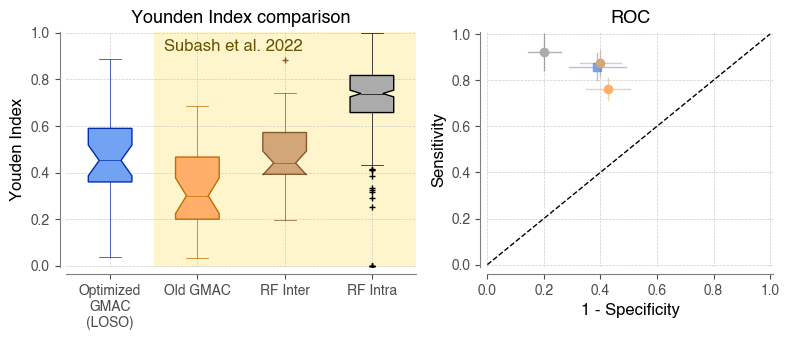

In [76]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
fig = plt.figure(figsize=(8, 3.5))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[4.4, 3.6])
ax = plt.subplot(gs[0, 0])

# Current performance
j = 1
ax.boxplot(x=looperf["youden"], positions=[j],
        widths=0.5, notch=True, patch_artist=True,
        boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
        capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
        whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
        flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                        markerfacecolor=darkc[j], marker='+', markersize=4),
        medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))

# Previous performance
# GMAC
j = 2
_vals = np.hstack([subash_perf_gmac["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTER
j = 3
_vals = np.hstack([subash_perf_rfinter["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTRA
j = 4
_vals = np.hstack([subash_perf_rfintra["youden"][i] for i in range(4)])
_vals = _vals[~np.isnan(_vals)]
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(-0.005, 1.005)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xticklabels(
    ["Optimized\nGMAC\n(LOSO)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOO Optimized GMAC
_valsens = looperf["sensitivity"]
_valspec = looperf["specificity"]
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=lightc[1], alpha=1)

# Old GMAC
_valsens = np.hstack([subash_perf_gmac["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_gmac["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[2], alpha=1)
# RF Inter
_valsens = np.hstack([subash_perf_rfinter["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfinter["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[3], alpha=1)
# RF Intra
_valsens = np.hstack([subash_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _ymean = np.nanmean(_valspec), np.nanmean(_valsens)
_xstd, _ystd = np.nanstd(_valspec), np.nanstd(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[4], alpha=1)
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "gmac_summary_all_med.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_summary_all_med.svg"), bbox_inches="tight")

#### Comparing performance with Subash et al. 2022 (means, CIs)

In [77]:
def compute_bootstrap_mean_ci(rawdata, n_bootstrap_samples=1000):
    # Find the bootstrap means and CIs.
    bootstrap_means = np.zeros(n_bootstrap_samples)
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(rawdata, size=len(rawdata), replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)
    return (np.nanmean(bootstrap_means),
            np.nanpercentile(bootstrap_means, [2.5, 97.5]))

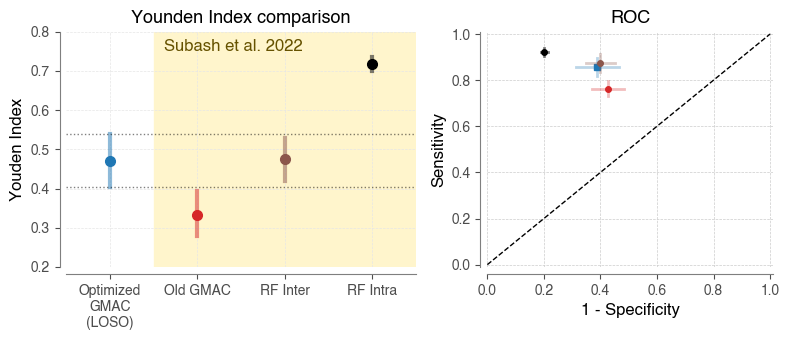

In [78]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
# darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
darkc = ["#a80a0a", "tab:blue", "tab:red", "tab:brown", "black", "#55552b", "#55552b"]
darkc_dict = {f"{i}": c for i, c in enumerate(darkc)}
fig = plt.figure(figsize=(8, 3.5))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[4.4, 3.6])

# Number of bootstrap samples
means = {}
ci95 = {}
# Find the bootstrap means and CIs.
means["newgmac"], ci95["newgmac"] = compute_bootstrap_mean_ci(looperf["youden"])
means["oldgmac"], ci95["oldgmac"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_gmac["youden"][i] for i in range(4)]))
means["rfinter"], ci95["rfinter"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_rfinter["youden"][i] for i in range(4)]))
means["rfintra"], ci95["rfintra"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_rfintra["youden"][i] for i in range(4)]))

ax = plt.subplot(gs[0, 0])
# Current performance
j = 1
ax.plot([j-0.], [means["newgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["newgmac"], color=darkc[j], lw=3, alpha=0.5)
ax.axhline(ci95["newgmac"][0], color="black", alpha=0.5, lw=1, ls="dotted")
ax.axhline(ci95["newgmac"][1], color="black", alpha=0.5, lw=1, ls="dotted")
j = 2
ax.plot([j-0.], [means["oldgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["oldgmac"], color=darkc[j], lw=3, alpha=0.5)
j = 3
ax.plot([j-0.], [means["rfinter"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfinter"], color=darkc[j], lw=3, alpha=0.5)
j = 4
ax.plot([j-0.], [means["rfintra"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfintra"], color=darkc[j], lw=3, alpha=0.5)

# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(0.2, 0.8)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.9', linestyle='--', linewidth=0.5);
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(
    ["Optimized\nGMAC\n(LOSO)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOO Optimized GMAC
_valsens = looperf["sensitivity"]
_valspec = looperf["specificity"]
_xmean, _xci = compute_bootstrap_mean_ci(looperf["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(looperf["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color=darkc[1], alpha=1)

# Old GMAC
_valsens = np.hstack([subash_perf_gmac["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_gmac["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[2], alpha=1)

# RF Inter
_valsens = np.hstack([subash_perf_rfinter["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfinter["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[3], alpha=1)

# RF Intra
_valsens = np.hstack([subash_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[4], alpha=1)

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "gmac_summary_all.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_summary_all.svg"), bbox_inches="tight")

## Inter-subject GMAC Model with validation (Leave-One-Subject)

In [79]:
# Add a healthy / stroke subject column
_subjtype = [
    f"H{_row[1]['subject']}" if _row[1]["limb"] in ["left", "right"]
    else f"S{_row[1]['subject']}"
    for i, _row in enumerate(gmac_perf[["subject", "limb"]].iterrows())
]
gmac_perf["subjtype"] = _subjtype
gmac_perf

,subject,np,fc,nc,nam,p_th,p_th_band,am_th,am_th_band,limb,...,FN,TP,TNr,FPr,FNr,TPr,sensitivity,specificity,youden,subjtype
0,2,1,0.01,2,1,-90,0,0.00,0,left,...,0,17133,0.000082,0.293752,0.000000,0.706166,1.00000,0.000281,0.000281,H2
1,2,1,0.01,2,1,-90,0,0.10,0,left,...,1500,15633,0.057003,0.236831,0.061825,0.644341,0.91245,0.193996,0.106446,H2
2,2,1,0.01,2,1,-90,0,0.25,0,left,...,7164,9969,0.156830,0.137004,0.295277,0.410889,0.58186,0.533735,0.115595,H2
3,2,1,0.01,2,1,-90,20,0.00,0,left,...,0,17133,0.000082,0.293752,0.000000,0.706166,1.00000,0.000281,0.000281,H2
4,2,1,0.01,2,1,-90,20,0.10,0,left,...,1500,15633,0.057003,0.236831,0.061825,0.644341,0.91245,0.193996,0.106446,H2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230845,5,50,1.00,2,50,90,60,0.10,0,unaff,...,15134,0,0.381301,0.000000,0.618699,0.000000,0.00000,1.000000,0.000000,S5
230846,5,50,1.00,2,50,90,60,0.25,0,unaff,...,15134,0,0.381301,0.000000,0.618699,0.000000,0.00000,1.000000,0.000000,S5
230847,5,50,1.00,2,50,90,80,0.00,0,unaff,...,15134,0,0.381301,0.000000,0.618699,0.000000,0.00000,1.000000,0.000000,S5
230848,5,50,1.00,2,50,90,80,0.10,0,unaff,...,15134,0,0.381301,0.000000,0.618699,0.000000,0.00000,1.000000,0.000000,S5


In [80]:
# Leave-one-out validation
subjs = list(set(gmac_perf.subjtype))

# Get performance for the different parameters combinations.
_keys = ["np", "fc", "nc", "nam", "p_th", "p_th_band", "am_th", "am_th_band"]
lens = [len(subjs)] + [len(gmac_param_ranges[_k]) for _k in _keys]
perf_loso = np.zeros(lens)
med = np.zeros(lens)
iqr = np.zeros(lens)

# All parameter combinations.
param_combs_enum = list(misc.generate_param_combinations_gmac_wenum(gmac_param_ranges))
for l, _subj in enumerate(subjs):
    # Index to leave out.
    _losoinx = ~(gmac_perf.subjtype == _subj)
    # Generate data for heatmap
    for i, pcvalenum in enumerate(param_combs_enum):
        _ix, _pcval = pcvalenum
        # Go through all limbs
        _inx = ((gmac_perf.np == _pcval["np"]) &
                (gmac_perf.fc == _pcval["fc"]) &
                (gmac_perf.nc == _pcval["nc"]) &
                (gmac_perf.nam == _pcval["nam"]) &
                (gmac_perf.am_th == _pcval["am_th"]) &
                (gmac_perf.am_th_band == _pcval["am_th_band"]) &
                (gmac_perf.p_th == _pcval["p_th"]) &
                (gmac_perf.p_th_band == _pcval["p_th_band"]))
        _vals = gmac_perf.loc[_losoinx & _inx, "youden"].values
        _ixstr = [f"{k}: {v:2d}" for k, v in _ix.items()]
        sys.stdout.write(f"\r{l:2d} {i:5d} {', '.join(_ixstr)}")
        sys.stdout.flush()
        # Compute the cost.
        # Compute performance.
        _perfs = [np.percentile(_vals, q) for q in [25, 50, 75]]
        _i = tuple([l]) + tuple(_ix[_k] for _k in _keys)
        perf_loso[_i] = _perfs[1] * (1 - (_perfs[2] - _perfs[0]))
        med[_i] = _perfs[1]
        iqr[_i] = _perfs[2] - _perfs[0]

# Save the perf data as a numpy file
np.save("../data/output-r1/all_perf_loso.npy", perf_loso)

14  7694 np:  2, fc:  2, nc:  0, nam:  2, p_th: 18, p_th_band:  4, am_th:  2, am_th_band:  0

In [81]:
maxinx = np.array([np.where(_perf == np.max(_perf)) for _perf in perf_loso]).T[0].T
bestarg = [
    [
        gmac_param_ranges["np"][_mx[0]],
        gmac_param_ranges["fc"][_mx[1]],
        gmac_param_ranges["nc"][_mx[2]],
        gmac_param_ranges["nam"][_mx[3]],
        gmac_param_ranges["p_th"][_mx[4]],
        gmac_param_ranges["p_th_band"][_mx[5]],
        gmac_param_ranges["am_th"][_mx[6]],
        gmac_param_ranges["am_th_band"][_mx[7]]
    ] for _mx in maxinx
]
bestarg

[[50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [25, 0.1, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.1, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.1, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [25, 0.1, 2, 25, 20, 60, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0]]

In [97]:
# Get the performance of the left out subject for the best parameters.
losoperf = {
    "youden": np.zeros(2 * len(subjs)),
    "sensitivity": np.zeros(2 * len(subjs)),
    "specificity": np.zeros(2 * len(subjs)),
}
# for i, (_lmb, _subj) in enumerate(subjs):
for i, _subj in enumerate(subjs):
    # Index to leave out.
    _looinx = (gmac_perf.subjtype == _subj)
    _inx = ((gmac_perf.np == bestarg[i][0]) &
            (gmac_perf.fc == bestarg[i][1]) &
            (gmac_perf.nc == bestarg[i][2]) &
            (gmac_perf.nam == bestarg[i][3]) &
            (gmac_perf.p_th == bestarg[i][4]) &
            (gmac_perf.p_th_band == bestarg[i][5]) &
            (gmac_perf.am_th == bestarg[i][6]) &
            (gmac_perf.am_th_band == bestarg[i][7]))
    # Computer performance
    losoperf["youden"][2 * i] = gmac_perf.loc[_looinx & _inx, "youden"].values[0]
    losoperf["youden"][2 * i + 1] = gmac_perf.loc[_looinx & _inx, "youden"].values[1]
    losoperf["sensitivity"][2 * i] = gmac_perf.loc[_looinx & _inx, "sensitivity"].values[0]
    losoperf["sensitivity"][2 * i + 1] = gmac_perf.loc[_looinx & _inx, "sensitivity"].values[1]
    losoperf["specificity"][2 * i] = gmac_perf.loc[_looinx & _inx, "specificity"].values[0]
    losoperf["specificity"][2 * i + 1] = gmac_perf.loc[_looinx & _inx, "specificity"].values[1]

#### Comparing performance with Subash et al. 2022

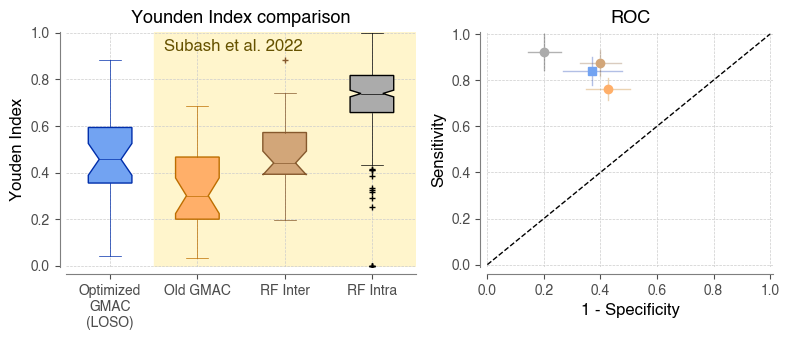

In [99]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
fig = plt.figure(figsize=(8, 3.5))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[4.4, 3.6])
ax = plt.subplot(gs[0, 0])

# Current performance
j = 1
ax.boxplot(x=losoperf["youden"], positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))

# Previous performance
# GMAC
j = 2
_vals = np.hstack([subash_perf_gmac["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTER
j = 3
_vals = np.hstack([subash_perf_rfinter["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTRA
j = 4
_vals = np.hstack([subash_perf_rfintra["youden"][i] for i in range(4)])
_vals = _vals[~np.isnan(_vals)]
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(-0.005, 1.005)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xticklabels(
    ["Optimized\nGMAC\n(LOSO)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOO Optimized GMAC
_valsens = losoperf["sensitivity"]
_valspec = losoperf["specificity"]
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=lightc[1], alpha=1)

# Old GMAC
_valsens = np.hstack([subash_perf_gmac["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_gmac["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[2], alpha=1)
# RF Inter
_valsens = np.hstack([subash_perf_rfinter["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfinter["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[3], alpha=1)
# RF Intra
_valsens = np.hstack([subash_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _ymean = np.nanmean(_valspec), np.nanmean(_valsens)
_xstd, _ystd = np.nanstd(_valspec), np.nanstd(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[4], alpha=1)
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "gmac_summary_all_med_loso.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_summary_all_med_loso.svg"), bbox_inches="tight")

#### Comparing performance with Subash et al. 2022 (means, CIs)

In [103]:
def compute_bootstrap_mean_ci(rawdata, n_bootstrap_samples=1000):
    # Find the bootstrap means and CIs.
    bootstrap_means = np.zeros(n_bootstrap_samples)
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(rawdata, size=len(rawdata), replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)
    return (np.nanmean(bootstrap_means),
            np.nanpercentile(bootstrap_means, [2.5, 97.5]))

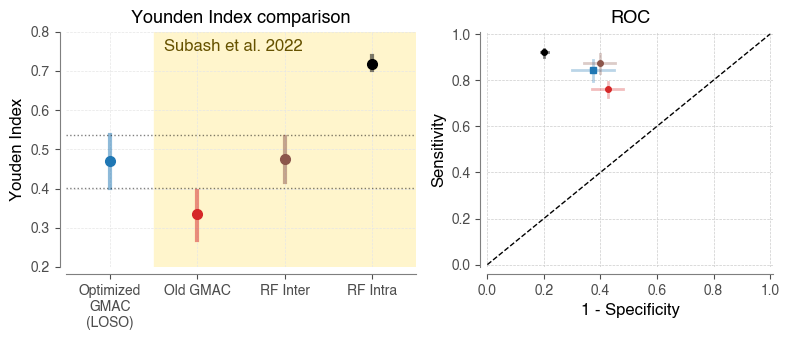

In [104]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
# darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
darkc = ["#a80a0a", "tab:blue", "tab:red", "tab:brown", "black", "#55552b", "#55552b"]
darkc_dict = {f"{i}": c for i, c in enumerate(darkc)}
fig = plt.figure(figsize=(8, 3.5))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[4.4, 3.6])

# Number of bootstrap samples
means = {}
ci95 = {}
# Find the bootstrap means and CIs.
means["newgmac"], ci95["newgmac"] = compute_bootstrap_mean_ci(losoperf["youden"])
means["oldgmac"], ci95["oldgmac"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_gmac["youden"][i] for i in range(4)]))
means["rfinter"], ci95["rfinter"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_rfinter["youden"][i] for i in range(4)]))
means["rfintra"], ci95["rfintra"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_rfintra["youden"][i] for i in range(4)]))

ax = plt.subplot(gs[0, 0])
# Current performance
j = 1
ax.plot([j-0.], [means["newgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["newgmac"], color=darkc[j], lw=3, alpha=0.5)
ax.axhline(ci95["newgmac"][0], color="black", alpha=0.5, lw=1, ls="dotted")
ax.axhline(ci95["newgmac"][1], color="black", alpha=0.5, lw=1, ls="dotted")
j = 2
ax.plot([j-0.], [means["oldgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["oldgmac"], color=darkc[j], lw=3, alpha=0.5)
j = 3
ax.plot([j-0.], [means["rfinter"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfinter"], color=darkc[j], lw=3, alpha=0.5)
j = 4
ax.plot([j-0.], [means["rfintra"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfintra"], color=darkc[j], lw=3, alpha=0.5)

# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(0.2, 0.8)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.9', linestyle='--', linewidth=0.5);
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(
    ["Optimized\nGMAC\n(LOSO)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOO Optimized GMAC
_valsens = losoperf["sensitivity"]
_valspec = losoperf["specificity"]
_xmean, _xci = compute_bootstrap_mean_ci(losoperf["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperf["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color=darkc[1], alpha=1)

# Old GMAC
_valsens = np.hstack([subash_perf_gmac["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_gmac["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[2], alpha=1)

# RF Inter
_valsens = np.hstack([subash_perf_rfinter["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfinter["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[3], alpha=1)

# RF Intra
_valsens = np.hstack([subash_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[4], alpha=1)

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "gmac_summary_all_loso.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_summary_all_loso.svg"), bbox_inches="tight")

### Table of Results

In [126]:
# Generate the result tables for individual subjects and limbs.
subjs = list(gmac_perf["subjtype"].unique())

# Get the performance of the left out subject for the best parameters.
losoperfdf = pd.DataFrame(columns=["subjtype", "subject", "limb", "type",
                                   "youden", "sensitivity", "specificity"])
for i, _subj in enumerate(subjs):
    # Index to leave out.
    _looinx = (gmac_perf.subjtype == _subj)
    # Right/Unaffecred limb
    _limbinx = gmac_perf.limb == ("right" if "H" in _subj else "unaff")
    _inx = ((gmac_perf.np == bestarg[i][0]) &
            (gmac_perf.fc == bestarg[i][1]) &
            (gmac_perf.nc == bestarg[i][2]) &
            (gmac_perf.nam == bestarg[i][3]) &
            (gmac_perf.p_th == bestarg[i][4]) &
            (gmac_perf.p_th_band == bestarg[i][5]) &
            (gmac_perf.am_th == bestarg[i][6]) &
            (gmac_perf.am_th_band == bestarg[i][7]))
    # Computer performance
    _fullinx = _looinx & _inx & _limbinx
    _perfdict = {
        "subjtype": [_subj],
        "subject": gmac_perf[_looinx]["subject"].unique(),
        "type": ["healthy" if "H" in _subj else "stroke"],
        "limb": gmac_perf[_fullinx]["limb"].unique(),
        "youden": gmac_perf.loc[_fullinx, "youden"].values,
        "sensitivity": gmac_perf.loc[_fullinx, "sensitivity"].values,
        "specificity": gmac_perf.loc[_fullinx, "specificity"].values,
    }
    losoperfdf = pd.concat([losoperfdf, pd.DataFrame.from_dict(_perfdict)],
                           ignore_index=True)
    # Left/Affecred limb
    _limbinx = gmac_perf.limb == ("left" if "H" in _subj else "aff")
    _inx = ((gmac_perf.np == bestarg[i][0]) &
            (gmac_perf.fc == bestarg[i][1]) &
            (gmac_perf.nc == bestarg[i][2]) &
            (gmac_perf.nam == bestarg[i][3]) &
            (gmac_perf.p_th == bestarg[i][4]) &
            (gmac_perf.p_th_band == bestarg[i][5]) &
            (gmac_perf.am_th == bestarg[i][6]) &
            (gmac_perf.am_th_band == bestarg[i][7]))
    # Computer performance
    _fullinx = _looinx & _inx & _limbinx
    _perfdict = {
        "subjtype": [_subj],
        "subject": gmac_perf[_looinx]["subject"].unique(),
        "type": ["healthy" if "H" in _subj else "stroke"],
        "limb": gmac_perf[_fullinx]["limb"].unique(),
        "youden": gmac_perf.loc[_fullinx, "youden"].values,
        "sensitivity": gmac_perf.loc[_fullinx, "sensitivity"].values,
        "specificity": gmac_perf.loc[_fullinx, "specificity"].values,
    }
    losoperfdf = pd.concat([losoperfdf, pd.DataFrame.from_dict(_perfdict)],
                           ignore_index=True)
losoperfdf.to_csv(f"{basedir}/losoperfdf.csv")

In [124]:
# Healthy - Right
_inx = ((losoperfdf["type"] == "healthy")
        & (losoperfdf["limb"] == "right"))
losoperfdf[_inx]

,subjtype,subject,limb,type,youden,sensitivity,specificity
0,H2,2,right,healthy,0.445169,0.974369,0.470800
2,H3,3,right,healthy,0.674786,0.776615,0.898170
4,H4,4,right,healthy,0.703542,0.961274,0.742268
6,H5,5,right,healthy,0.720958,0.924846,0.796112
8,H6,6,right,healthy,0.526907,0.664806,0.862101
10,H7,7,right,healthy,0.477791,0.888150,0.589641
12,H8,8,right,healthy,0.472739,0.916917,0.555823
14,H9,9,right,healthy,0.884187,0.929606,0.954581
16,H10,10,right,healthy,0.520301,0.763613,0.756687
18,H1,1,right,healthy,0.595870,0.916184,0.679686


In [159]:
# Cols to get
cols = ["subject", "method", "type", "limb", "youden", "sensitivity", "specificity"]
# RF intra Summary DF
subashsummdf = pd.DataFrame(columns=cols)

# Go through all limbs
limbtypes = [("right", "healthy"), ("left", "healthy"), ("unaff", "stroke"), ("aff", "stroke")]
methods = ["GMAC", "RF intra", "RF inter"]
for (_l, _t) in limbtypes:
    for _m in methods:
        _inx1 = subash22df[_l]["method"] == _m
        for _s in subash22df[_l]["subject"].unique():
            _inx2 = _inx1 & (subash22df[_l]["subject"] == _s)
            _perfdict = {
                "subject": [_s],
                "method": [_m],
                "limb": [_l],
                "type": [_t],
                "youden": [np.mean(subash22df[_l][_inx2]["youden"])],
                "sensitivity": [np.mean(subash22df[_l][_inx2]["sensitivity"])],
                "specificity": [np.mean(subash22df[_l][_inx2]["specificity"])],
            }
            subashsummdf = pd.concat([subashsummdf,
                                    pd.DataFrame.from_dict(_perfdict)],
                                    ignore_index=True)
subashsummdf.to_csv(f"{basedir}/subashsummdf.csv")

In [156]:
subash22df["right"]["method"].unique()

array(['Activity Counts', 'Vector Magnitude', 'GM Score', 'GMAC',
       'RF intra', 'RF inter', 'SVM intra', 'SVM inter', 'MLP intra',
       'MLP inter'], dtype=object)

### ROC Plots for GMAC for different parameter combination

In [228]:
import random

In [246]:
# Healthy subject indidces
_subjs = [_s for _s in gmac_perf["subjtype"].unique() if 'H' in _s]
healthy_inx = gmac_perf["subjtype"] == _subjs[0]
for _s in _subjs[1:]:
    healthy_inx = healthy_inx | (gmac_perf["subjtype"] == _s)
_subjs = [_s for _s in gmac_perf["subjtype"].unique() if 'S' in _s]
stroke_inx = gmac_perf["subjtype"] == _subjs[0]
for _s in _subjs[1:]:
    stroke_inx = stroke_inx | (gmac_perf["subjtype"] == _s)

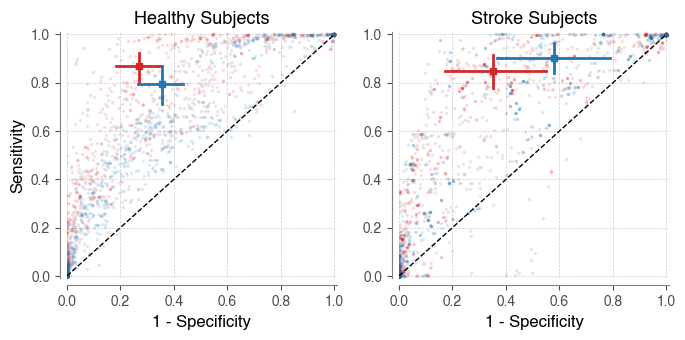

In [257]:

# Figure.
fig = plt.figure(figsize=(7, 3.5))
ax = fig.add_subplot(121)
# Get Sens, and Spec.
# Number of bootstrap samples
means = {}
ci95 = {}

# Find the bootstrap means and CIs.
# Right Limb
_inxhr = ((losoperfdf["type"] == "healthy") &
          (losoperfdf["limb"] == "right"))
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["specificity"].values)
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["sensitivity"].values)
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:red", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:red", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:red", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "right")
N = np.sum(healthy_inx & limb_inx)
_randinx = np.random.choice(N, 1000, replace=False)
_spec = 1 - gmac_perf[healthy_inx & limb_inx]["specificity"].values
_sens = gmac_perf[healthy_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:red", marker=".", markersize=3,
        alpha=0.1, linestyle="None")

# Left Limb
_inxhr = ((losoperfdf["type"] == "healthy") &
          (losoperfdf["limb"] == "left"))
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["specificity"].values)
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["sensitivity"].values)
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:blue", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:blue", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:blue", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "left")
N = np.sum(healthy_inx & limb_inx)
_randinx = np.random.choice(N, 1000, replace=False)
_spec = 1 - gmac_perf[healthy_inx & limb_inx]["specificity"].values
_sens = gmac_perf[healthy_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:blue", marker=".", markersize=3,
        alpha=0.1, linestyle="None")
# ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:blue", alpha=1)

ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("Healthy Subjects", fontsize=13)

ax = fig.add_subplot(122)
# Unaffected Limb
_inxhr = ((losoperfdf["type"] == "stroke") &
          (losoperfdf["limb"] == "unaff"))
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["specificity"].values)
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["sensitivity"].values)
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:red", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:red", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:red", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "unaff")
N = np.sum(stroke_inx & limb_inx)
_randinx = np.random.choice(N, 1000, replace=False)
_spec = 1 - gmac_perf[stroke_inx & limb_inx]["specificity"].values
_sens = gmac_perf[stroke_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:red", marker=".", markersize=3,
        alpha=0.1, linestyle="None")

# Left Limb
_inxhr = ((losoperfdf["type"] == "stroke") &
          (losoperfdf["limb"] == "aff"))
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["specificity"].values)
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["sensitivity"].values)
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:blue", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:blue", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:blue", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "aff")
N = np.sum(stroke_inx & limb_inx)
_randinx = np.random.choice(N, 1000, replace=False)
_spec = 1 - gmac_perf[stroke_inx & limb_inx]["specificity"].values
_sens = gmac_perf[stroke_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:blue", marker=".", markersize=3,
        alpha=0.1, linestyle="None")
# ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:blue", alpha=1)

ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
# ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("Stroke Subjects", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "ROC_loso.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "ROC_loso.svg"), bbox_inches="tight")

#### Pairwise comparison with old GMAC

In [188]:
from scipy import stats

In [199]:
outcome = "specificity"

In [200]:
# Limbs
model = "GMAC"
limbs = ["left", "right", "aff", "unaff"]
diff_perf = [[], []]

# LOO Inter-Subject
for i, (_lmb, _subj) in enumerate(limbsubj):
    # LOO perf
    _looinx = ((gmac_perf.limb == _lmb) &
               (gmac_perf.subject == _subj))
    _inx = ((gmac_perf.am_th == bestargs[i][0]) &
            (gmac_perf.am_th_band == 0) &
            (gmac_perf.p_th == bestargs[i][1]) &
            (gmac_perf.p_th_band == bestargs[i][2]))
    _perf1 = gmac_perf[_inx & _looinx][outcome].values[0]
    # Subash perf
    _minx = subash22df[_lmb].method == model
    _sinx = (subash22df[_lmb]["subject"] == _subj)
    _perf2 = subash22df[_lmb][_minx & _sinx][outcome].values[0]
    diff_perf[0].append(_perf1)
    diff_perf[1].append(_perf2)

# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(diff_perf[0], diff_perf[1])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05
print(f"[{model}], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = np.array(diff_perf[0]) - np.array(diff_perf[1])
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")
# print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

[GMAC], specificity
Not significant
0.003 $\pm$ 0.217


In [201]:
# Limbs
model = "RF inter"
limbs = ["left", "right", "aff", "unaff"]
diff_perf = [[], []]

# LOO Inter-Subject
for i, (_lmb, _subj) in enumerate(limbsubj):
    # LOO perf
    _looinx = ((gmac_perf.limb == _lmb) &
               (gmac_perf.subject == _subj))
    _inx = ((gmac_perf.am_th == bestargs[i][0]) &
            (gmac_perf.am_th_band == 0) &
            (gmac_perf.p_th == bestargs[i][1]) &
            (gmac_perf.p_th_band == bestargs[i][2]))
    _perf1 = gmac_perf[_inx & _looinx][outcome].values[0]
    # Subash perf
    _minx = subash22df[_lmb].method == model
    _sinx = (subash22df[_lmb]["subject"] == _subj)
    _perf2 = subash22df[_lmb][_minx & _sinx][outcome].values[0]
    diff_perf[0].append(_perf1)
    diff_perf[1].append(_perf2)

# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(diff_perf[0], diff_perf[1])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05
print(f"[{model}], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = np.array(diff_perf[0]) - np.array(diff_perf[1])
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

[RF inter], specificity
Not significant
-0.024 $\pm$ 0.213


In [202]:
# Limbs
model = "RF intra"
limbs = ["left", "right", "aff", "unaff"]
diff_perf = [[], []]

# LOO Inter-Subject
for i, (_lmb, _subj) in enumerate(limbsubj):
    # LOO perf
    _looinx = ((gmac_perf.limb == _lmb) &
               (gmac_perf.subject == _subj))
    _inx = ((gmac_perf.am_th == bestargs[i][0]) &
            (gmac_perf.am_th_band == 0) &
            (gmac_perf.p_th == bestargs[i][1]) &
            (gmac_perf.p_th_band == bestargs[i][2]))
    _perf1 = gmac_perf[_inx & _looinx][outcome].values[0]
    # Subash perf
    _minx = subash22df[_lmb].method == model
    _sinx = (subash22df[_lmb]["subject"] == _subj)
    _perf2 = np.nanmean(subash22df[_lmb][_minx & _sinx][outcome].values)
    diff_perf[0].append(_perf1)
    diff_perf[1].append(_perf2)

# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(diff_perf[0], diff_perf[1])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05
print(f"[{model}], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = np.array(diff_perf[0]) - np.array(diff_perf[1])
print(f"{np.nanmean(_diff):0.3f} $\\pm$ {np.nanstd(_diff):0.3f}")

[RF intra], specificity
0.000
-0.222 $\pm$ 0.259


### Compute GMAC for the best parameters

In [221]:
# GMAC Parameter ranges
gmac_param = {
    "np": int(Fs // 2),
    "fc": 0.1,
    "nc": 2,
    "nam": int(5*Fs),
    "p_th": 10,
    "p_th_band": 40,
    "am_th": 0.1,
    "am_th_band": 0
}

# Estimate pitch for each subject.
accl_cols = ['ax', 'ay', 'az']
dfcols = (["subject", "limb", "pitch", "am", "gmac", "gt"])
gmac_raw_df = pd.DataFrame(columns=dfcols)
for limbkey in ["left", "right", "aff", "unaff"]:
    # Which limb?
    limbdf = datadf[limbkey]
    subjects = limbdf.subject.unique()
    for i, subj in enumerate(subjects):
        # Go through all parameter combinations.
        _sinx = limbdf.subject == subj
        sys.stdout.write(f"\r{limbkey} {i:3d}")
        df = limbdf[limbdf.subject==subj]
        # Compute gmac
        _gmacout = [
            gmac.estimate_gmac2(_df[accl_cols].values, accl_farm_inx=0, Fs=Fs,
                                params=gmac_param, full_output=True)
            for _, _df in df.groupby('segment')
        ]
        # Pitch
        _pitch = np.hstack([_gmac[0] for _gmac in _gmacout])
        _am = np.hstack([_gmac[1] for _gmac in _gmacout])
        _gmac = np.hstack([_gmac[2] for _gmac in _gmacout])
        _rawdf = pd.DataFrame(
            np.vstack([_pitch, _am, _gmac, df.gnd.values]).T,
            columns=["pitch", "am", "gmac", "gt"]
        )
        _rawdf["subject"] = subj
        _rawdf["limb"] = limbkey
        gmac_raw_df = pd.concat(
            (gmac_raw_df, _rawdf),
            ignore_index=True
        )

unaff   4

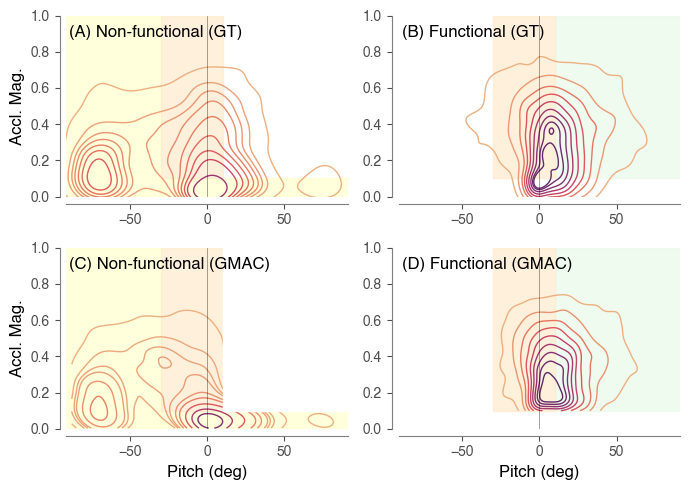

In [360]:
# Scatter plot of pitch vs. am for different classes
M = 100
fig = plt.figure(figsize=(7, 5))
# Ground truth
ax = plt.subplot(2, 2, 1)
# Backgrounds
# u = 0
background = plt.Rectangle((-100, 0), 70, 1.0,
                           transform=ax.transData,
                           color='#ffffcc', zorder=-1, alpha=0.7)
ax.add_patch(background)
background = plt.Rectangle((-30, 0), 130, 0.1,
                           transform=ax.transData,
                           color='#ffffcc', zorder=-1, alpha=0.7)
ax.add_patch(background)
# u = 0/1
background = plt.Rectangle((-30, 0.1), 40, 0.9,
                           transform=ax.transData,
                           color='#ffebcc', zorder=-1, alpha=0.7)
ax.add_patch(background)
_inx = gmac_raw_df["gt"] == 0
sns.kdeplot(x=gmac_raw_df.loc[_inx, "pitch"].values[::M],
            y=gmac_raw_df.loc[_inx, "am"].values[::M],
            levels=10, cmap='flare', linewidths=1.0)
ax.axvline(x=0, lw=0.5, color="black", alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
# ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Accl. Mag.", fontsize=12)
# ax.set_title(r"$u\left(t\right) = 0$", fontsize=13)
ax.set_xlim(-91, 91)
ax.set_ylim(0.0, 1.0)
ax.text(0.01, 0.95, "(A) Non-functional (GT)", ha="left", va="top", fontsize=12,
        color="#000", transform=ax.transAxes,)

ax = plt.subplot(2, 2, 2)
# Backgrounds
# u = 1
background = plt.Rectangle((10, 0.1), 90, 0.9,
                           transform=ax.transData,
                           color='#eafaea', zorder=-1, alpha=0.7)
ax.add_patch(background)
# u = 0/1
background = plt.Rectangle((-30, 0.1), 40, 0.9,
                           transform=ax.transData,
                           color='#ffebcc', zorder=-1, alpha=0.7)
ax.add_patch(background)
_inx = gmac_raw_df["gt"] == 1
sns.kdeplot(x=gmac_raw_df.loc[_inx, "pitch"].values[::M],
            y=gmac_raw_df.loc[_inx, "am"].values[::M],
            levels=10, cmap='flare', linewidths=1.0)
ax.axvline(x=0, lw=0.5, color="black", alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
# ax.grid(color='0.8', linestyle='--', linewidth=0.5);
# ax.set_xlabel("Pitch (deg)", fontsize=12)
# ax.set_title(r"$u\left(t\right) = 1$", fontsize=13)
ax.set_xlim(-91, 91)
ax.set_ylim(0.0, 1.0)
ax.text(0.01, 0.95, "(B) Functional (GT)", ha="left", va="top", fontsize=12,
        color="#000", transform=ax.transAxes,)

# Actual GMAC
ax = plt.subplot(2, 2, 3)
# Backgrounds
# u = 0
background = plt.Rectangle((-100, 0), 70, 1.0,
                           transform=ax.transData,
                           color='#ffffcc', zorder=-1, alpha=0.7)
ax.add_patch(background)
background = plt.Rectangle((-30, 0), 130, 0.1,
                           transform=ax.transData,
                           color='#ffffcc', zorder=-1, alpha=0.7)
ax.add_patch(background)
# u = 0/1
background = plt.Rectangle((-30, 0.1), 40, 0.9,
                           transform=ax.transData,
                           color='#ffebcc', zorder=-1, alpha=0.7)
ax.add_patch(background)
_inx = gmac_raw_df["gmac"] == 0
sns.kdeplot(x=gmac_raw_df.loc[_inx, "pitch"].values[::M],
            y=gmac_raw_df.loc[_inx, "am"].values[::M],
            levels=10, cmap='flare', linewidths=1.0,
            cut=0)
ax.axvline(x=0, lw=0.5, color="black", alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
# ax.grid(color='0.8', linestyle='--', linewidth=0.5, zorder=3);
ax.set_xlabel("Pitch (deg)", fontsize=12)
ax.set_ylabel("Accl. Mag.", fontsize=12)
# ax.set_title(r"$u\left(t\right) = 0$", fontsize=13)
ax.set_xlim(-91, 91)
ax.set_ylim(0.0, 1.0)
ax.text(0.01, 0.95, "(C) Non-functional (GMAC)", ha="left", va="top", fontsize=12,
        color="#000", transform=ax.transAxes,)
background = plt.Rectangle((10, 0.1), 80, 1.0,
                           transform=ax.transData,
                           color='#fff', zorder=2)
ax.add_patch(background)

ax = plt.subplot(2, 2, 4)
# Backgrounds
# u = 1
background = plt.Rectangle((10, 0.1), 90, 0.9,
                           transform=ax.transData,
                           color='#eafaea', zorder=-1, alpha=0.7)
ax.add_patch(background)
# u = 0/1
background = plt.Rectangle((-30, 0.1), 40, 0.9,
                           transform=ax.transData,
                           color='#ffebcc', zorder=-1, alpha=0.7)
ax.add_patch(background)
_inx = gmac_raw_df["gmac"] == 1
sns.kdeplot(x=gmac_raw_df.loc[_inx, "pitch"].values[::M],
            y=gmac_raw_df.loc[_inx, "am"].values[::M],
            levels=10, cmap='flare', linewidths=1.0,
            cut=0)
ax.axvline(x=0, lw=0.5, color="black", alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
# ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xlabel("Pitch (deg)", fontsize=12)
ax.set_xlim(-91, 91)
ax.set_ylim(0.0, 1.0)
ax.text(0.01, 0.95, "(D) Functional (GMAC)", ha="left", va="top", fontsize=12,
        color="#000", transform=ax.transAxes,)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "gt_gmac_hist_contours.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gt_gmac_hist_contours.svg"), bbox_inches="tight")

## Intra-subject GMAC Model with validation
Compute the peformanance for each subject for each parameter combination across
the different segments.

In [86]:
perf = np.zeros((len(limbsubj),
                 len(gmac_param_ranges["am_th"]),
                 len(gmac_param_ranges["p_th"]),
                 len(gmac_param_ranges["p_th_band"])))

In [101]:
segs

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [155]:
# Find the best parameter for each subject and each limb.
segs = gmac_perf_intra.segment.unique()
_inx1 = (gmac_perf_intra.am_th_band == 0)
for l, (limb, subj) in enumerate(limbsubj):
    linx = (gmac_perf_intra.limb == limb)
    sinx = (gmac_perf_intra.subject == subj)
    trinx = (gmac_perf_intra.type == "train")
    # Go through each parameter combination
    _youden = np.zeros((10,
                        len(gmac_param_ranges["am_th"]),
                        len(gmac_param_ranges["p_th"]),
                        len(gmac_param_ranges["p_th_band"])))
    for i, _amth in enumerate(gmac_param_ranges["am_th"]):
        _inx2 = (gmac_perf_intra.am_th == _amth)
        for j, _pth in enumerate(gmac_param_ranges["p_th"]):
            _inx3 = (gmac_perf_intra.p_th == _pth)
            for k, _pthb in enumerate(gmac_param_ranges["p_th_band"]):
                _inx4 = (gmac_perf_intra.p_th_band == _pthb)
                for m, seg in enumerate(segs):
                    _inx = (linx & sinx &  trinx & 
                            _inx1 & _inx2 & _inx3 & _inx4 &
                            (gmac_perf_intra.segment == seg))
                    _youden[m, i, j, k] = gmac_perf_intra.loc[_inx, "youden"].values[0]
                    sys.stdout.write(f"\r{l, i, j, k, m} ")
    # Compute the perforamance across segments for all parameter combinations.
    _youdsumm = [np.nanpercentile(_youden, q, axis=0) for q in [25, 50, 75]]
    perf[l, :, :, :] = _youdsumm[1] * (1 - (_youdsumm[2] - _youdsumm[0]))

(29, 3, 18, 4, 9) 

In [156]:
# Find the best parameters for each subject.
maxinx = np.array([np.array(np.where(_perf == np.max(_perf))).T[0] for _perf in perf])
bestargs = np.array([(gmac_param_ranges["am_th"][_mxix[0]],
                      gmac_param_ranges["p_th"][_mxix[1]],
                      gmac_param_ranges["p_th_band"][_mxix[2]])
                     for _mxix in maxinx])
bestargs

array([[  0.  ,  20.  ,  80.  ],
       [  0.1 ,  10.  ,  40.  ],
       [  0.  ,  20.  ,  80.  ],
       [  0.  ,  10.  ,  40.  ],
       [  0.  ,  40.  ,  80.  ],
       [  0.  ,  10.  ,  40.  ],
       [  0.  ,  10.  ,  40.  ],
       [  0.  ,  20.  ,  60.  ],
       [  0.1 ,  10.  ,  40.  ],
       [  0.1 ,  20.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ],
       [  0.  ,  10.  ,  40.  ],
       [  0.  ,  20.  ,  60.  ],
       [  0.  ,  20.  ,  40.  ],
       [  0.  ,  10.  ,  20.  ],
       [  0.  ,  20.  ,  80.  ],
       [  0.25, -30.  ,   0.  ],
       [  0.1 ,  20.  ,  80.  ],
       [  0.1 ,   0.  ,  20.  ],
       [  0.1 ,   0.  ,  20.  ],
       [  0.1 ,  40.  ,  40.  ],
       [  0.  ,   0.  ,  40.  ],
       [  0.  ,  40.  ,  80.  ],
       [  0.  ,  10.  ,  40.  ],
       [  0.  ,  20.  ,  40.  ],
       [  0.  ,  10.  ,  40.  ],
       [  0.1 , -10.  ,  20.  ],
       [  0.1 ,  20.  ,  40.  ],
       [  0.  ,  20.  ,  60.  ],
       [  0.1 ,   0.  ,  20.  ]])

In [157]:
# Get the performance of the left out subject for the best parameters.
kfoldperf = {
    "youden": np.zeros(len(limbsubj)),
    "sensitivity": np.zeros(len(limbsubj)),
    "specificity": np.zeros(len(limbsubj)),
}
for i, (_lmb, _subj) in enumerate(limbsubj):
    # Index to leave out.
    _kfinx = ((gmac_perf_intra.limb == _lmb) &
               (gmac_perf_intra.subject == _subj) &
               (gmac_perf_intra.type != "train"))
    _inx = ((gmac_perf_intra.am_th == bestargs[i][0]) &
            (gmac_perf_intra.am_th_band == 0) &
            (gmac_perf_intra.p_th == bestargs[i][1]) &
            (gmac_perf_intra.p_th_band == bestargs[i][2]))
    # Computer performance
    kfoldperf["youden"][i] = np.nanpercentile(gmac_perf_intra.loc[_kfinx & _inx, "youden"].values, 50)
    kfoldperf["sensitivity"][i] = np.nanpercentile(gmac_perf_intra.loc[_kfinx & _inx, "sensitivity"].values, 50)
    kfoldperf["specificity"][i] = np.nanpercentile(gmac_perf_intra.loc[_kfinx & _inx, "specificity"].values, 50)

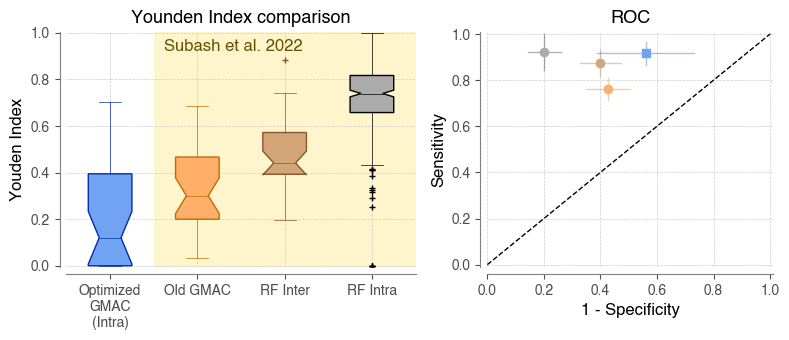

In [161]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
fig = plt.figure(figsize=(8, 3.5))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[4.4, 3.6])
ax = plt.subplot(gs[0, 0])

# Current performance
# _vals = np.hstack([curr_perf["youden"][i][j] for i in range(4)])
# j = 0
# ax.boxplot(x=nolooperf, positions=[j],
#         widths=0.5, notch=True, patch_artist=True,
#         boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
#         capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
#         whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
#         flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
#                         markerfacecolor=darkc[j], marker='+', markersize=4),
#         medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
j = 1
ax.boxplot(x=kfoldperf["youden"], positions=[j],
        widths=0.5, notch=True, patch_artist=True,
        boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
        capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
        whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
        flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                        markerfacecolor=darkc[j], marker='+', markersize=4),
        medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))

# Previous performance
# GMAC
j = 2
_vals = np.hstack([subash_perf_gmac["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTER
j = 3
_vals = np.hstack([subash_perf_rfinter["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTRA
j = 4
_vals = np.hstack([subash_perf_rfintra["youden"][i] for i in range(4)])
_vals = _vals[~np.isnan(_vals)]
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(-0.005, 1.005)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xticklabels(
    ["Optimized\nGMAC\n(Intra)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOO Optimized GMAC
_valsens = kfoldperf["sensitivity"]
_valspec = kfoldperf["specificity"]
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=lightc[1], alpha=1)

# Old GMAC
_valsens = np.hstack([subash_perf_gmac["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_gmac["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[2], alpha=1)
# RF Inter
_valsens = np.hstack([subash_perf_rfinter["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfinter["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[3], alpha=1)
# RF Intra
_valsens = np.hstack([subash_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _ymean = np.nanmean(_valspec), np.nanmean(_valsens)
_xstd, _ystd = np.nanstd(_valspec), np.nanstd(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[4], alpha=1)
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()